In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

In [5]:
# from imblearn.combine import SMOTETomek
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import TomekLinks
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.under_sampling import OneSidedSelection

In [3]:
import time
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [4]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

## Using OCC+SMOTE+CC Samples

### Getting Data

In [5]:
res = pd.read_csv('../Outputs/resampled.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [6]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [14]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 10, 500),
        'max_depth':trial.suggest_int('max_depth', 1, 10)
    }
    
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred = rf_model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [15]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=20)

[I 2024-06-04 19:30:28,737] A new study created in memory with name: no-name-27a761c7-8c55-4c33-9da5-a14693673c91
[I 2024-06-04 19:32:00,093] Trial 0 finished with value: 0.5992087960531252 and parameters: {'n_estimators': 441, 'max_depth': 7}. Best is trial 0 with value: 0.5992087960531252.
[I 2024-06-04 19:32:46,959] Trial 1 finished with value: 0.598370178960006 and parameters: {'n_estimators': 314, 'max_depth': 5}. Best is trial 0 with value: 0.5992087960531252.
[I 2024-06-04 19:33:09,363] Trial 2 finished with value: 0.5900809915960081 and parameters: {'n_estimators': 301, 'max_depth': 2}. Best is trial 0 with value: 0.5992087960531252.
[I 2024-06-04 19:34:54,440] Trial 3 finished with value: 0.5993197081113529 and parameters: {'n_estimators': 499, 'max_depth': 7}. Best is trial 3 with value: 0.5993197081113529.
[I 2024-06-04 19:35:27,221] Trial 4 finished with value: 0.5954703796803482 and parameters: {'n_estimators': 121, 'max_depth': 9}. Best is trial 3 with value: 0.5993197081

In [25]:
rf_model = RandomForestClassifier(n_estimators=500, max_depth=7)
rf_model.fit(X_res, y_res) 

RandomForestClassifier(max_depth=7, n_estimators=500)

### Making Predictions

In [33]:
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

### Ploting and Metrics

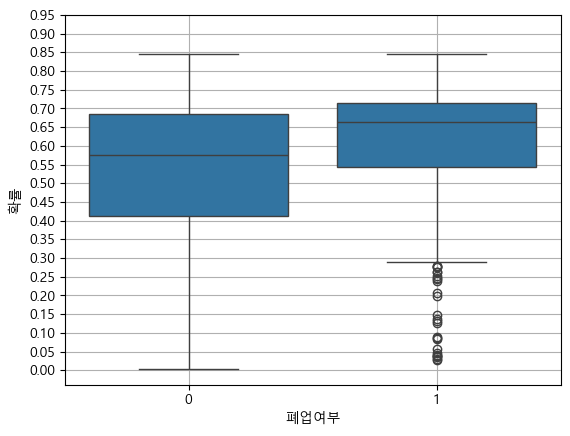

In [34]:
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp)
plt.yticks(np.arange(0, 1, 0.05))
plt.grid(True)
plt.show()

0.5


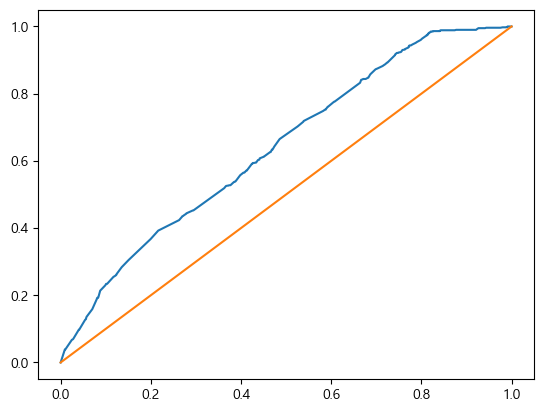

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='roc')
plt.plot([0, 1], [0, 1])
print(roc_auc_score(y_test, y_pred))

In [57]:
threshold = 0.60
y_pred = (y_pred_prob >= threshold).astype('int')

In [58]:
print("0-1 proportion at test set :", list(y_test.value_counts()))
print("accuracy :", accuracy_score(y_test, y_pred))
print("precisoin :", precision_score(y_test, y_pred))
print("recall :", recall_score(y_test, y_pred))
print("f1 :", f1_score(y_test, y_pred))
print("roc score ", roc_auc_score(y_test, y_pred))

0-1 proportion at test set : [53308, 800]
accuracy : 0.9852147556738375
precisoin : 0.0
recall : 0.0
f1 : 0.0
roc score  0.5


c:\Users\HOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

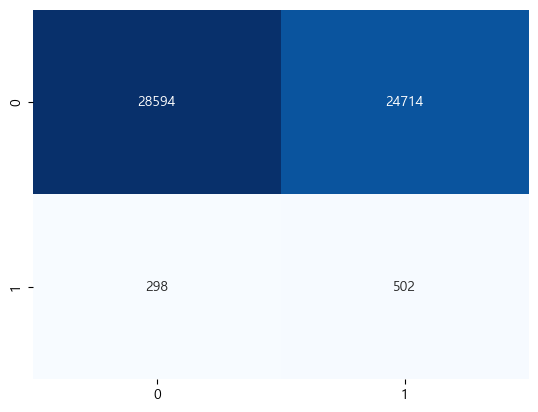

In [40]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cbar = False, annot=True, cmap = 'Blues', fmt='g')

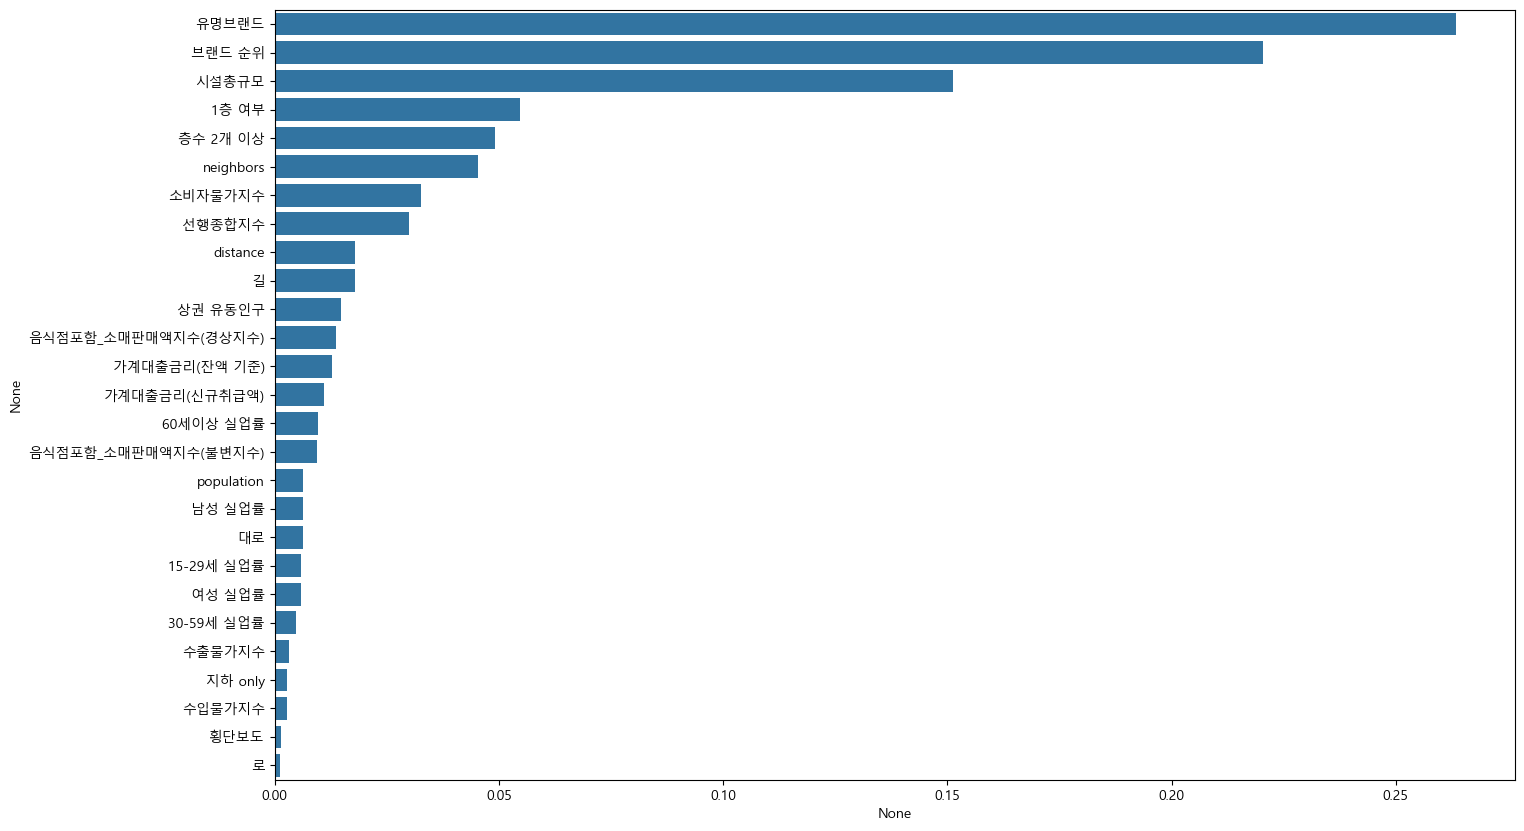

In [42]:
## Feature Importance
ser = pd.Series(rf_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()

## Using SMOTETomek

### Getting Data

In [43]:
res = pd.read_csv('../Outputs/resampled_smt.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set_smt.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [44]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [48]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 10, 500),
        'max_depth':trial.suggest_int('max_depth', 1, 10)
    }
    
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred = rf_model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [49]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=20)

[I 2024-06-04 20:01:31,723] A new study created in memory with name: no-name-3fc871d7-ebf7-4ae2-b34a-82a964b91d7b
[I 2024-06-04 20:07:11,911] Trial 0 finished with value: 0.5788225969835672 and parameters: {'n_estimators': 431, 'max_depth': 6}. Best is trial 0 with value: 0.5788225969835672.
[I 2024-06-04 20:08:07,148] Trial 1 finished with value: 0.5816794852554963 and parameters: {'n_estimators': 180, 'max_depth': 2}. Best is trial 1 with value: 0.5816794852554963.
[I 2024-06-04 20:10:44,358] Trial 2 finished with value: 0.5748570571021235 and parameters: {'n_estimators': 152, 'max_depth': 8}. Best is trial 1 with value: 0.5816794852554963.
[I 2024-06-04 20:18:56,183] Trial 3 finished with value: 0.5756178247167405 and parameters: {'n_estimators': 443, 'max_depth': 9}. Best is trial 1 with value: 0.5816794852554963.
[I 2024-06-04 20:19:51,435] Trial 4 finished with value: 0.5826756302993922 and parameters: {'n_estimators': 82, 'max_depth': 5}. Best is trial 4 with value: 0.5826756302

In [50]:
study.best_params

{'n_estimators': 304, 'max_depth': 1}

In [51]:
rf_model = RandomForestClassifier(n_estimators=304, max_depth=1)
rf_model.fit(X_res, y_res) 

RandomForestClassifier(max_depth=1, n_estimators=304)

### Making Predictions

In [70]:
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

### Ploting and Metrics

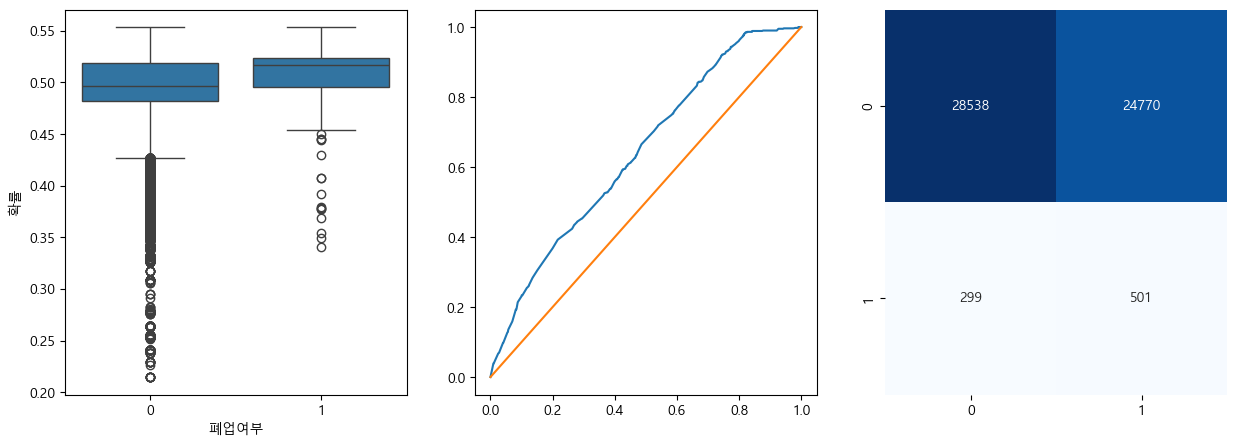

In [94]:
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='폐업여부', y='확률', ax = ax[0], data=temp)
# plt.yticks(np.arange(0, 1, 0.05))
# plt.grid(True)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
ax[1].plot(fpr, tpr, label='roc')
ax[1].plot([0, 1], [0, 1])

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cbar = False, ax = ax[2], annot=True, cmap = 'Blues', fmt='g')

plt.show()

In [73]:
print("0-1 proportion at test set :", list(y_test.value_counts()))
print("accuracy :", accuracy_score(y_test, y_pred))
print("precisoin :", precision_score(y_test, y_pred))
print("recall :", recall_score(y_test, y_pred))
print("f1 :", f1_score(y_test, y_pred))
print("roc score ", roc_auc_score(y_test, y_pred))

0-1 proportion at test set : [53308, 800]
accuracy : 0.5366858874842907
precisoin : 0.019825095959795813
recall : 0.62625
f1 : 0.03843350849603007
roc score  0.5807958936744954


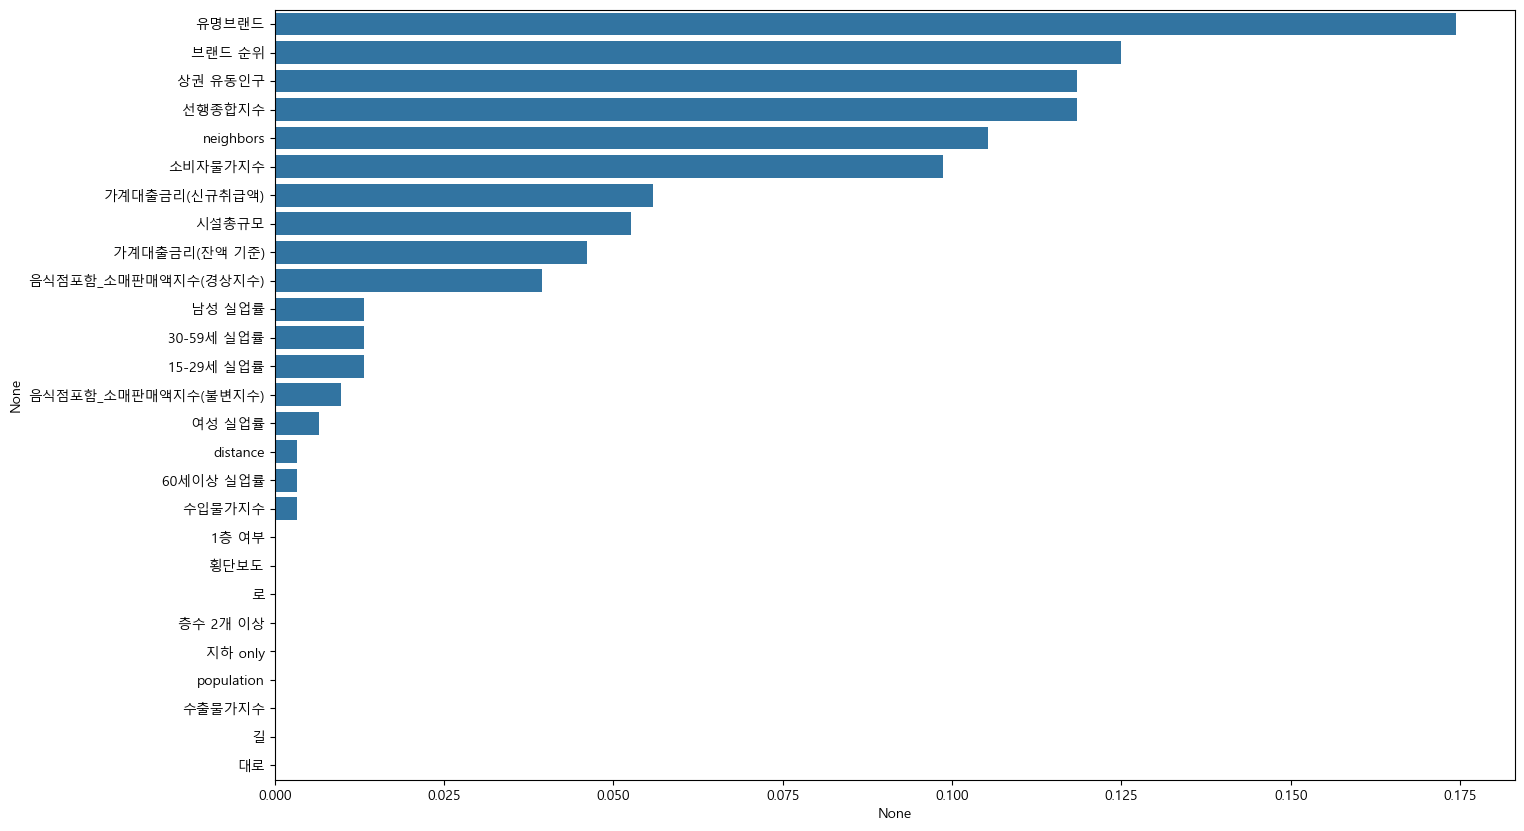

In [75]:
## Feature Importance
ser = pd.Series(rf_model.feature_importances_, index=X_res.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()